# Crystal Size Distribution (CSD) for a cooling liquid

This notebook is a first attempt to model the evolution of the crystal size
distribution (CSD) as a function of time as a packet of liquid cools through
its melting temperature. The general idea is based on Spillar and Dolejs (2013;
Journal of Petrology 54:913-931, https://academic.oup.com/petrology/article/54/5/913/1431429) but instead of attempting to invert a measured
CSD to find cooling history we will impose a cooling history and calculate the
resulting CSD. Another paper worth reading is Marsh (1998; Journal of Petrology 
39:553-599), which sets up much of the background.

The CSD, $n(L, t)$ describes the number density of crystals of radius $L$ in a
volume of liquid at time $t$. Its evolution with time depends on a balance of 
the nucleation rate, $I$, and the crystal growth rate, $G$. Both of these are 
functions that are equal to zero at the melting temperature, $T_m$, and which
increase with undercolling. For almost all igneous rocks all the melt has
crystalised and this imposes geometic  constraints that modifies the
behaviour of $I$ and $G$. But we are interested in low crystallinity, so
we will assume that $I$ and $G$ are only controlled by the thermodynamic 
and kinetic effects.

I will use some data for Cu, because this seems to be hanging around, assume
growth rate is linear, and take a simple form for G (really we should use
equation 5 from Davies et al. 2019; EPSL 507:1-9, but that has too many terms for
me today).


# Crystallility

Spillar and Dejoes (2013) equation (2) is:

$$ \Psi(t) = \frac{4\pi}{3} \int_0^t I(\tau) \left[ \int_{\tau}^t G(\tau^{\prime}) d\tau^{\prime}  \right]^3 d \tau .$$

Let $G$ and $I$ be constants. We then get 

$$ \int_{\tau}^t G(\tau^{\prime}) d\tau^{\prime} = \left[  G\tau^{\prime} \right]_{\tau}^t = G(t-\tau)$$ 

and 

$$ \Psi(t) = \frac{4\pi I G^3}{3} \int_0^t \left[ G(t-\tau) \right]^3 .$$

Now

$$ \left[ G(t-\tau) \right]^3 = t^3 - \tau^3 + 3 \tau^2 t - 3t^2\tau  \Rightarrow \int_0^t \left[ G(t-\tau) \right]^3 d\tau = \left[ t^3\tau - \frac{\tau^4}{4} + 3\tau^3 t - 3\tau^2 t^2   \right]_0^t = t^4 - \frac{t^4}{4} + 3t^4 - \frac{3t^4}{2} = \frac{9t^4}{4}. $$

The final result is then

$$ \Psi(t) = 3\pi I G^3 t^4 $$

In [1]:
import time

import numba
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Data for Cu (because I have a EAM set up in LAMMPS for Cu in case we want to take it further)

kB = 1.380649e-23 # J/K
cu_k0 = 212 * 1E-4 # [K^-1]? Table 2 # and made 1000 times smaller
cu_tm = 1275 # [K] Table 1
cu_dhm = 1.21 * kB * cu_tm # [J] SI table S1, heat of fusion at melting point
g_factor = 2E6 # A constant for the nucleation rate.

In [3]:
def growth_rate(t, tm, dhm, k0):
    """
    Linear growth rate - see Sun et al. Nat Materials paper
    t is the temperature
    Tm is the melting temperature
    dmu is the difference in chekical potentials
    k0 is a rate constant
    r is the particle radius
    """
    d_mu = (tm - t) * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    v = k0 * (1.0 - np.exp(-d_mu/(kB * t)))
    return v


In [4]:
def nucleation_rate(t, tm, dhm, surf_e):
    """
    Simple nucleation rate. Just say it goes with the square of the undercooling...
    ... need to do better
    t is the temperature
    Tm is the melting temperature
    dmu is the difference in chekical potentials
    k0 is a rate constant
    r is the particle radius
    """
    d_mu = (tm - t)**2 * (dhm / tm) # K13 / first para of Sun SI
    kB = 1.380649e-23 #J/K
    g = surf_e * (1.0 - np.exp(-d_mu/(kB * t)))
    return g

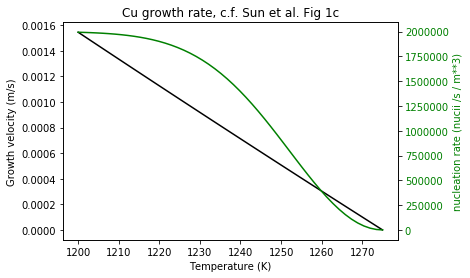

In [5]:
fig, ax = plt.subplots()
ts = np.linspace(1200, cu_tm)
vs = growth_rate(ts, cu_tm, cu_dhm, cu_k0)
gs = nucleation_rate(ts, cu_tm, cu_dhm, g_factor)
ax.plot(ts, vs, 'k')
ax2 = ax.twinx()
ax2.plot(ts, gs, 'g')
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Growth velocity (m/s)')
ax2.tick_params(axis='y', labelcolor='g')
ax2.set_ylabel('nucleation rate (nucii /s / m**3)', color='g')
ax.set_title('Cu growth rate, c.f. Sun et al. Fig 1c')
plt.show()

We need some temperature history for our melt packet. Linear cooling for now.
We will run to 1200 K. So set up some empty arrays.

In [6]:
total_volume = 1.0 # m^3
initial_temperature = 1275.0 #  below tm!
cooling_rate = 0.1 # K/s
end_temperature = 1265 # K
# Volume is 1 m**3
max_time = (initial_temperature - end_temperature) / cooling_rate
print("Run time will be", max_time, "seconds")
time_step = 0.005 # s
n_steps = int(max_time / time_step)
print("Will run for", n_steps, "steps")
times = np.arange(0, max_time, time_step)

Run time will be 100.0 seconds
Will run for 20000 steps


In [7]:
# Set up discritisation for the CSD
# This is a log of the particle size
min_r = 0.000001
# We could integrate G to get Lmax (see S&D18) but let's just set up a fixed value
max_r = 0.1
num_r = 1000
sizes = np.geomspace(min_r, max_r, num=num_r, endpoint=True)
sizes_lower = np.zeros_like(sizes)
for i in range(1, num_r):
    sizes_lower[i] = sizes[i-1] + (sizes[i] - sizes[i-1])/2.0
    
print("Will have", num_r, "size bins in the csd with log distribution")
print("First bin runs from r = ", sizes_lower[0], "to r = ", sizes_lower[1], 
      "with r = ", sizes[0], "assumed")
print("Second bin runs from r = ", sizes_lower[1], "to r = ", sizes_lower[2], 
      "with r = ", sizes[1], "assumed")
print("Minimum dr to grow:", sizes_lower[1] - sizes[0])
print("Last bin runs from r = ", sizes_lower[-1], "upwards", 
      "with r = ", sizes[-1], "assumed")

Will have 1000 size bins in the csd with log distribution
First bin runs from r =  0.0 to r =  1.0057955561119148e-06 with r =  1e-06 assumed
Second bin runs from r =  1.0057955561119148e-06 to r =  1.0174538452770371e-06 with r =  1.0115911122238297e-06 assumed
Minimum dr to grow: 5.795556111914849e-09
Last bin runs from r =  0.09942708510959787 upwards with r =  0.1 assumed


In [8]:
# Build the CSD array
csd = np.zeros((n_steps, num_r), dtype='int')
print("csd array shape and size:", csd.shape, csd.size)

csd array shape and size: (20000, 1000) 20000000


In [9]:
@numba.jit(nopython=True)
def iterate_csd(csd_in, sizes, sizes_lower, dr):
    """
    Grow the crystals in an arbitary crystal size distribution by dr
    
    The CSD must be a 1D integer array containing the number of 
    crystals in each size bin. Crystal sizes (radii) for each bin are given
    by the sizes array, and the lower bound for each bin is given by
    the sizes_lower array. Growth rate is given by dr. Bins do not
    have to have equal spacing. Returns a new, updated CSD.
    
    num_r  = integer number of bins
    csd_in = initial distribution of particles
    sizes  = mid radius of each bin
    dr = increase in particle radius due to growth
    """
    csd_out = np.zeros_like(csd_in)
    assert csd_in.shape == sizes.shape, "Arrays must match size"
    assert csd_in.shape == sizes_lower.shape, "Arrays must match size"
    assert len(csd_in.shape) == 1, "Arrays must be 1D"
    assert dr >= 0, "Not set up for dissolution yet"
    num_r = csd_in.size
    
    for j in range(num_r-1):
        if csd_in[j] == 0:
            # No particles to grow, skip!
            pass
        elif sizes[j] + dr < sizes_lower[j + 1]:
            # Particles not grown enough to get into next bin
            csd_out[j] = csd_out[j] + csd_in[j]
        else:
            for jj in range(num_r-1, j-1, -1):
                # Particles grown, add them to the first bin found, looping back from biggest
                if sizes[j] + dr > sizes_lower[jj]:
                    csd_out[jj] = csd_out[jj] + csd_in[j]
                    break
                # assert "Error! Should never get here"
    # Particles in the biggest bin do not grow
    csd_out[num_r-1] = csd_out[num_r-1] + csd_in[num_r-1]
    
    return csd_out

In [10]:
def csd_evolve(csd, sizes, sizes_lower, temperature, times, time_step,
               f_growth_rate, f_nucleation_rate):
    
    temperature_log[0] = temperature
    crystalinity_log[0] = np.sum(csd[0,:] * (4/3) * np.pi * sizes**3) / total_volume

    for ii, t in enumerate(times[1:]):
        i = ii + 1 # To deal with enumerate starting from 0.
    
        # Grow the CSD
        v = f_growth_rate(temperature, cu_tm, cu_dhm, cu_k0)
        assert v >= 0.0, "Not set up for dissolution"
        dr = v * time_step # How far does a surface grow?
        # Assume v is positive (growth)
        # and move from large to small growing crystals.
        # Move CSD from cell j in time t-1 to j+delta_j at time t
        csd[i, :] = iterate_csd(csd[i-1, :], sizes, sizes_lower, dr)
        
        # Nucleation (always at L=0, i.e assume nuclii are small)
        g = f_nucleation_rate(temperature, cu_tm, cu_dhm, g_factor) 
        csd[i,0] = csd[i,0] + int(g * time_step) # Assume 1 m**3 box
    
        temperature_log[i] = temperature
        crystalinity_log[i] = np.sum(csd[i,:] * (4/3) * np.pi * sizes**3) / total_volume
    
    
        if i%2500 == 0:
            print("\nStep:", i, "time:", t)
            print("temperature:", temperature, "g:", g, "v", v)
            print("dr", dr)
            print("New partcles this step", int(g * time_step))
            print("Max size particles this step", csd[i,-1])
            print("Total particles:", np.sum(csd[i,:]))
            print("Instant CSD sample (every 50th bin):", csd[i,::50])
            print("Instant crystalinity:", crystalinity_log[i])
            print("Wall time per timestep:", (time.time() - start_time) / i)
        if crystalinity_log[i] >= 1.0:
            print("\nFrozen!")
            print("\nStep:", i, "time:", t)
            print("temperature:", temperature, "g:", g, "v", v)
            print("dr", dr)
            print("New partcles this step", int(g * time_step))
            print("Max size particles this step", csd[i,-1])
            print("Total particles:", np.sum(csd[i,:]))
            print("Instant CSD sample (every 50th bin):", csd[i,::50])
            print("Instant crystalinity:", crystalinity_log[i])
            print("Wall time per timestep:", (time.time() - start_time) / i)
            break
        temperature = temperature - (cooling_rate*time_step)
        
    print("Done")
    return csd, temperature_log, crystalinity_log

In [11]:
start_time = time.time()
temperature_log = np.zeros_like(times)
crystalinity_log = np.zeros_like(times)

# Initial condition
temperature = initial_temperature
csd[0, :] = 0 

csd, temperature_log, crystalinity_log = csd_evolve(csd, sizes, 
                sizes_lower, temperature, times, time_step,
               growth_rate, nucleation_rate)




Step: 2500 time: 12.5
temperature: 1273.7504999997454 g: 2964.022568005431 v 2.5148692114107796e-05
dr 1.25743460570539e-07
New partcles this step 14
Max size particles this step 0
Total particles: 11237
Instant CSD sample (every 50th bin): [14  0  0  0 13 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Instant crystalinity: 4.2570207434232103e-10
Wall time per timestep: 0.00023495960235595702

Step: 5000 time: 25.0
temperature: 1272.5004999994908 g: 11846.070974886436 v 5.032692687623843e-05
dr 2.5163463438119216e-07
New partcles this step 59
Max size particles this step 0
Total particles: 96431
Instant CSD sample (every 50th bin): [59  0  0  0  0 57 56  0  0  0  0  0  0  0  0  0  0  0  0  0]
Instant crystalinity: 3.152779228294782e-08
Wall time per timestep: 0.00019379420280456544

Step: 7500 time: 37.5
temperature: 1271.2504999992361 g: 26584.497484935855 v 7.552464947918516e-05
dr 3.776232473959258e-07
New partcles this step 132
Max size particles this step 0
Total particles: 329354

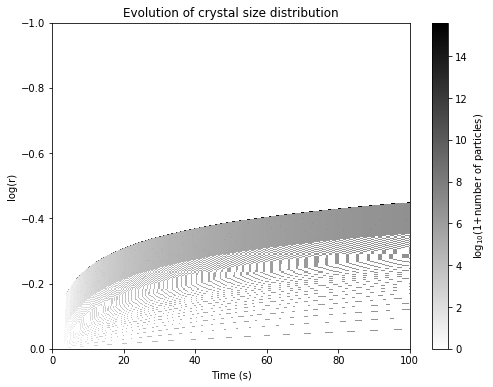

In [12]:
fig, ax = plt.subplots(figsize=(8,6))

extent = (0, max_time, 0, np.log10(max_r),)
cols = ax.imshow(np.log(csd[0::20,:]+1).T, aspect='auto', interpolation='none', origin='lower', 
                 cmap='gray_r', extent=extent)
ax.set_title('Evolution of crystal size distribution')
ax.set_xlabel('Time (s)')
ax.set_ylabel('log(r)')
cbar = fig.colorbar(cols, ax=ax)
cbar.ax.set_ylabel('log$_{10}$(1+number of particles)')

plt.show()

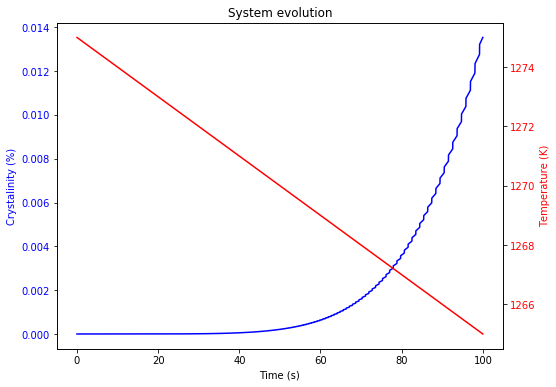

In [13]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(times, crystalinity_log*100, 'b')
ax2 = ax.twinx()
ax2.plot(times, temperature_log, 'r')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Crystalinity (%)', color='b' )
ax.tick_params(axis='y', labelcolor='b' )
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Temperature (K)', color='r')
ax.set_title('System evolution')

plt.show()

In [14]:
# Set up discritisation for the CSD
# This is a the particle size
min_r = 0.000001
# We could integrate G to get Lmax (see S&D18) but let's just set up a fixed value
max_r = 0.001
num_r = 10000
sizes = np.linspace(min_r, max_r, num=num_r, endpoint=True)
sizes_lower = np.zeros_like(sizes)
for i in range(1, num_r):
    sizes_lower[i] = sizes[i-1] + (sizes[i] - sizes[i-1])/2.0
    
print("Will have", num_r, "size bins in the csd with linear distribution")
print("First bin runs from r = ", sizes_lower[0], "to r = ", sizes_lower[1], 
      "with r = ", sizes[0], "assumed")
print("Second bin runs from r = ", sizes_lower[1], "to r = ", sizes_lower[2], 
      "with r = ", sizes[1], "assumed")
print("Minimum dr to grow:", sizes_lower[1] - sizes[0])
print("Last bin runs from r = ", sizes_lower[-1], "upwards", 
      "with r = ", sizes[-1], "assumed")

# Build the CSD array
csd = np.zeros((n_steps, num_r), dtype='int')
print("csd array shape and size:", csd.shape, csd.size)

Will have 10000 size bins in the csd with linear distribution
First bin runs from r =  0.0 to r =  1.04995499549955e-06 with r =  1e-06 assumed
Second bin runs from r =  1.04995499549955e-06 to r =  1.1498649864986498e-06 with r =  1.0999099909990998e-06 assumed
Minimum dr to grow: 4.9954995499550024e-08
Last bin runs from r =  0.0009999500450045004 upwards with r =  0.001 assumed
csd array shape and size: (20000, 10000) 200000000


In [15]:
start_time = time.time()
temperature_log = np.zeros_like(times)
crystalinity_log = np.zeros_like(times)

# Initial condition
temperature = initial_temperature
csd[0, :] = 0 

csd, temperature_log, crystalinity_log = csd_evolve(csd, sizes, 
                sizes_lower, temperature, times, time_step,
               growth_rate, nucleation_rate)


Step: 2500 time: 12.5
temperature: 1273.7504999997454 g: 2964.022568005431 v 2.5148692114107796e-05
dr 1.25743460570539e-07
New partcles this step 14
Max size particles this step 0
Total particles: 11237
Instant CSD sample (every 50th bin): [14 14 13 13 12 12 11 10 10  9  9  9  8  8  7  7  6  6  6  5  5  4  4  4
  4  3  3  3  2  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
Instant crystalinity: 2.6042999616926372e-08
Wall time per timestep: 0.003955163288116455

Step: 5000 time: 25.0
temperature: 1272.5004999994908 g: 

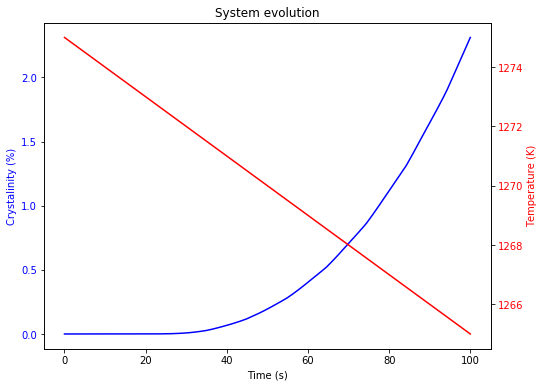

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(times, crystalinity_log*100, 'b')
ax2 = ax.twinx()
ax2.plot(times, temperature_log, 'r')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Crystalinity (%)', color='b' )
ax.tick_params(axis='y', labelcolor='b' )
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylabel('Temperature (K)', color='r')
ax.set_title('System evolution')

plt.show()

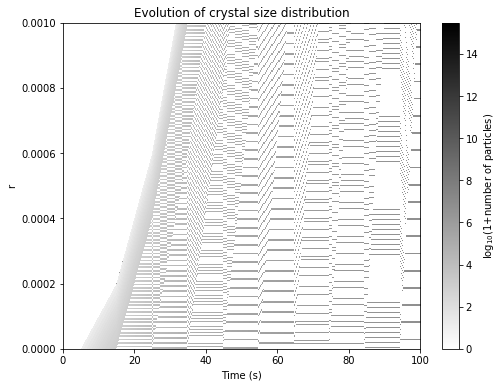

In [19]:
fig, ax = plt.subplots(figsize=(8,6))

extent = (0, max_time, 0, max_r)
cols = ax.imshow(np.log(csd[0::20,:]+1).T, aspect='auto', interpolation='none', origin='lower', 
                 cmap='gray_r', extent=extent)
ax.set_title('Evolution of crystal size distribution')
ax.set_xlabel('Time (s)')
ax.set_ylabel('r')
cbar = fig.colorbar(cols, ax=ax)
cbar.ax.set_ylabel('log$_{10}$(1+number of particles)')

plt.show()